In [13]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
# Load pickles

file = open('final_df_pickle_v1.0', 'rb')
final_df = pickle.load(file)
file.close()

file = open('actor_bday_v1.0', 'rb')
bday_dict = pickle.load(file)
file.close()

In [15]:
# more_bdays_df = pd.read_csv("name.basics.tsv", sep="\t")

# file = open('more_bdays_df', 'wb')
# pickle.dump(more_bdays_df, file)
# file.close()

In [16]:
file = open('more_bdays_df', 'rb')
more_bdays_df = pickle.load(file)
file.close()
more_bdays_df = more_bdays_df[['primaryName','birthYear']]

In [17]:
master_bdays_df = more_bdays_df[more_bdays_df['primaryName'].isin(list(set(final_df['star'])))]
master_bdays_df.shape

(2018, 2)

In [18]:
master_bdays_df[master_bdays_df['primaryName']=='Tom Cruise'].iloc[0]['birthYear'].isnumeric()

True

In [19]:
def get_bday(star):
    try:
        counter = 0
        while master_bdays_df[master_bdays_df['primaryName']==star].iloc[counter]['birthYear'].isnumeric() != True:
            counter += 1
        return master_bdays_df[master_bdays_df['primaryName']==star].iloc[counter]['birthYear']
    except:
        return None

final_df['birth_year'] = final_df['star'].apply(get_bday)
print('Still missing bdays for ' + str(sum([1 for i in final_df['birth_year'].isna() if i])) + ' actors')
missing_list = final_df[final_df['birth_year'].isna()]['star']

Still missing bdays for 3 actors


In [20]:
print(len(set(missing_list)))
set(missing_list)

# Drop stars with no birthdays
final_df.dropna(inplace=True)
print(final_df.shape)

final_df.reset_index(inplace=True)

3
(1513, 18)


In [21]:
# Adjust datatypes
to_numeric_cols = ['budget','imdb_rating','meta_rating','runtime','usa_gross']
for i in to_numeric_cols:
    final_df[i] = pd.DataFrame(final_df[i], dtype='float')
final_df['year'] = pd.DataFrame(final_df['year'], dtype='int')
final_df['birth_year'] = pd.DataFrame(final_df['birth_year'], dtype='int')

# Add interesting columns

final_df['profit'] = final_df['usa_gross'] - final_df['budget']
final_df['log_usa_gross'] = np.log(list(final_df['usa_gross']))
final_df['log_budget'] = np.log(list(final_df['budget']))
final_df['gross_budget_ratio'] = final_df['usa_gross'] / final_df['budget']
final_df['log_gb_ratio'] = np.log(list(final_df['gross_budget_ratio']))
final_df['log_gb_diff'] = final_df['log_usa_gross'] - final_df['log_budget']
final_df['age_of_star'] = final_df['year'] - final_df['birth_year']

# Narrow genres
fix_genre_dict = {'Mystery': 'Crime', 'Romance': 'Drama', 'Fantasy': 'Adventure', 
                  'Sci-Fi': 'Adventure', 'Family': 'Animation', 'Musical': 'Animation'}
fixed_genres = []
for i in final_df['genres']:
    if i in fix_genre_dict:
        fixed_genres.append(fix_genre_dict[i])
    else:
        fixed_genres.append(i)
final_df['fixed_genres'] = fixed_genres

In [22]:
# Consider dropping outliers
# low_cut = final_df['log_gb_ratio'].quantile(.005)
# high_cut = final_df['log_gb_ratio'].quantile(.995)
# for i, val in enumerate(final_df['log_gb_ratio']):
#     if (val <= low_cut) or (val >= high_cut):
#         final_df.loc[i,'log_gb_ratio'] = None
        
# final_df.dropna(inplace=True)
# final_df.reset_index(drop=True, inplace=True)

In [23]:
# Feature engineering

star_profit = final_df.groupby(by=['star','year']).mean()['usa_gross']

# Previous N year's box office gross of star
def get_star_power(star, year, N):
    past_bank = star_profit.loc[star].loc[year-N:year-1]
    if list(past_bank) == []:
        return 100000
    else:
        return np.mean(past_bank)

past_bank_short = []
past_bank_long = []
for i, val in enumerate(final_df['star']):
    past_bank_short.append(get_star_power(val, final_df['year'].iloc[i], 1))
    past_bank_long.append(get_star_power(val, final_df['year'].iloc[i], 10))
    
final_df['past_bank_short'] = past_bank_short
final_df['past_bank_long'] = past_bank_long
final_df['log_past_bank_short'] = np.log(past_bank_short)
final_df['log_past_bank_long'] = np.log(past_bank_long)

quant_cols = ['log_gb_ratio','num_critics','meta_rating','runtime','year', 'age_of_star',
              'past_bank_short', 'past_bank_long',
              'log_past_bank_short', 'log_past_bank_long']

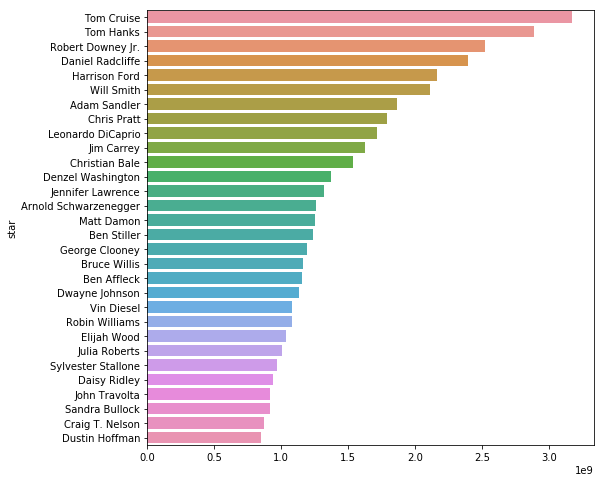

In [24]:
# Best/Worst Actors (Sum over Career)

career_star_profit = star_profit.groupby(by='star').sum().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

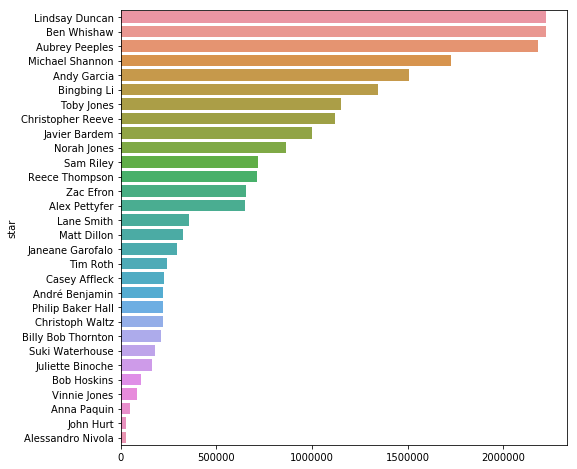

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

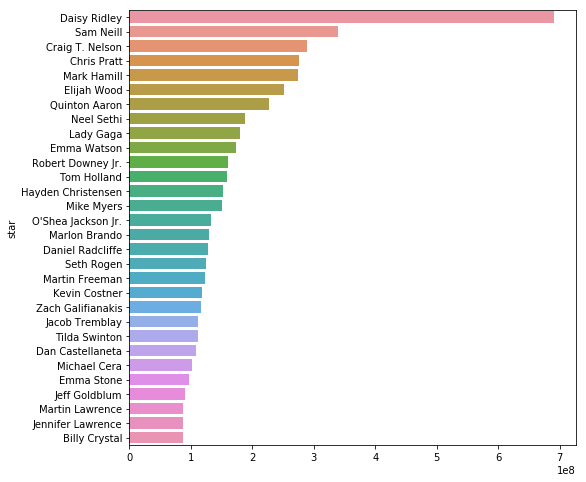

In [26]:
# Best/Worst Actors (Mean over Career)

star_profit = final_df.groupby(by=['star','year']).mean()['profit']
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[0:30]
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

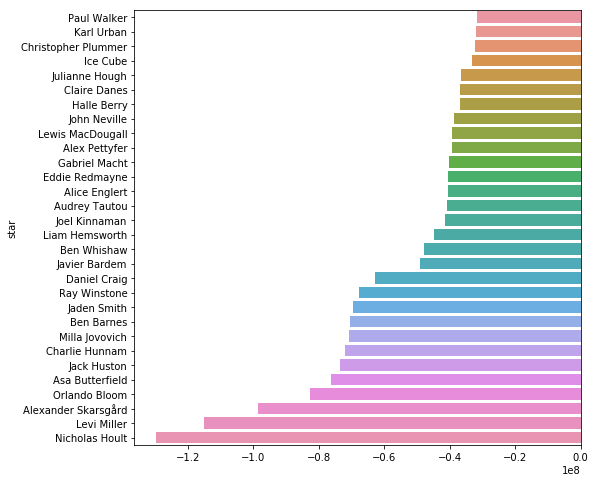

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
career_star_profit = star_profit.groupby(by='star').mean().sort_values(ascending=False)[-30:]
sns.barplot(x=career_star_profit.values, y=career_star_profit.index);

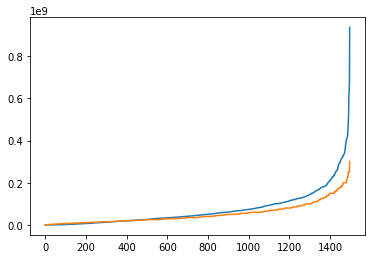

In [28]:
sorted_gross = list(final_df['usa_gross'].sort_values(ascending=True))
sorted_budget = list(final_df['budget'].sort_values(ascending=True))
plt.plot(sorted_gross)
plt.plot(sorted_budget);

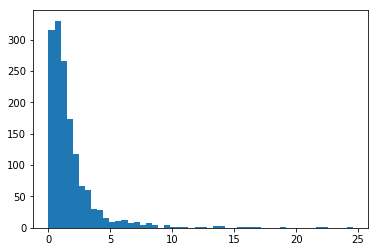

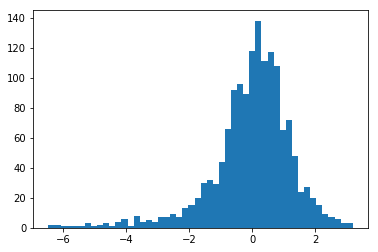

In [29]:
sorted_gb_ratio = list(final_df['gross_budget_ratio'].sort_values(ascending=True))
sorted_log_gb_ratio = list(final_df['log_gb_ratio'].sort_values(ascending=True))
sorted_log_gb_ratio = list(final_df['log_gb_ratio'].sort_values(ascending=True))

plt.hist(sorted_gb_ratio, bins=50)
plt.show()
plt.hist(sorted_log_gb_ratio, bins=50);

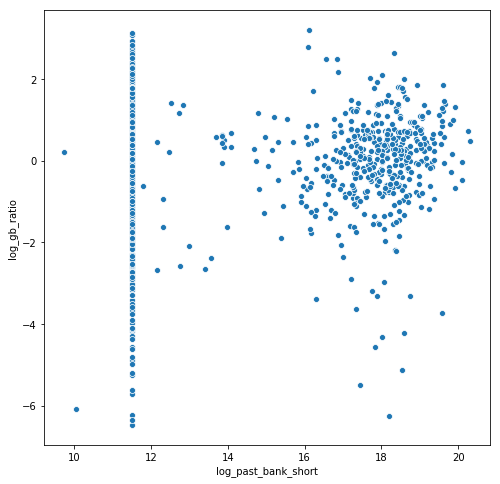

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='log_past_bank_short', y='log_gb_ratio', data=final_df);

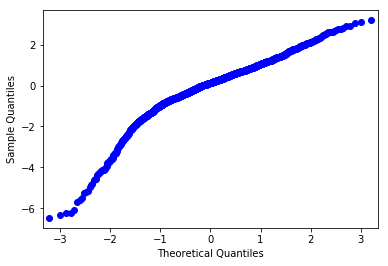

In [31]:
sm.qqplot(final_df['log_gb_ratio']);

In [32]:
# Log(Box office performance) <- to make this more normally distributed
    # = intercept 
    # + B1*month_of_release + B2*weather + B3*meta_rating + B4*unemployment_rate 
    # + B5*genre + B6*budget + B7*is_sequel + B8*interaction_term(for whether previous was good)
    # + B9*age_of_star + B10*rating_of_movie + B11*past_ROI_of_star + B12*past_critic_of_director
    # + B13*decade + B14*oscar_count_star1_star2_director + B15*is_original_screenplay
    # + B16*contrarian_genre <- is the genre sparse or frequent lately?
    
# Maybe the supporting star matters more than the star (cuz he/she is cheaper)

In [33]:
# Process categorical variables for regression

def get_label_list(value_counts, enc):
    col_sums = np.sum(enc, axis=0)
    col_labels = []
    for i in col_sums:
        counter = 0
        for j in value_counts:
            if i == j:
                col_labels.append(value_counts.index[counter])
                break
            counter += 1
    return col_labels

values = np.array(final_df['fixed_genres'])
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((-1,1))

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
enc_genre = enc.fit_transform(integer_encoded)
genre_labels = get_label_list(final_df['fixed_genres'].value_counts(), enc_genre)

enc_genre_df = pd.DataFrame(enc_genre, columns=genre_labels)

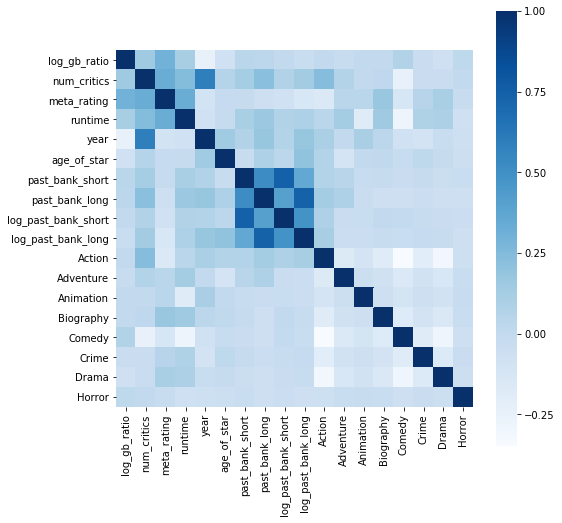

In [34]:
quant_df = final_df[quant_cols].copy()
quant_df = pd.DataFrame(quant_df, dtype='float')
quant_df = pd.concat([quant_df, enc_genre_df], axis=1)

corrs = quant_df.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrs, square=True, cmap="Blues");

In [35]:
regr = linear_model.LinearRegression()

x_cols = ['num_critics','meta_rating','runtime','year', 'age_of_star','log_past_bank_short','log_past_bank_long']
[x_cols.append(i) for i in genre_labels[:-1]]

x = quant_df[x_cols]
y = quant_df['log_gb_ratio']
regr.fit(x, y)

y_pred = regr.predict(x)

# The coefficients
print('Intecept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.3f"
      % mean_squared_error(y, y_pred))
print('R^2: %.3f' % r2_score(y, y_pred))
print('Adjusted R^2: %.3f' % r2_score(y, y_pred))

n = y.shape[0]
p = len(x_cols)
adj_r2 = 1 - (1 - r2_score(y, y_pred)) * (n - 1)/(n - p - 1)

Intecept: 
 133.57933554606765
Coefficients: 
 [ 0.00390484  0.11271735 -0.0008456  -0.06743319 -0.00295978  0.00441611
  0.01085231  0.02449971 -0.18687822  0.42889815  0.0459854   0.43659802
 -0.22439821 -0.14223174]
Mean squared error: 1.244
R^2: 0.251
Adjusted R^2: 0.251


In [36]:
# Sanity Check with StatsModel

x_const = sm.add_constant(x, prepend=True)
model = sm.OLS(y, x_const)

fitted_model = model.fit()

print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gb_ratio   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     35.48
Date:                Thu, 11 Apr 2019   Prob (F-statistic):           5.73e-83
Time:                        23:28:05   Log-Likelihood:                -2287.7
No. Observations:                1497   AIC:                             4605.
Df Residuals:                    1482   BIC:                             4685.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 133.5793    

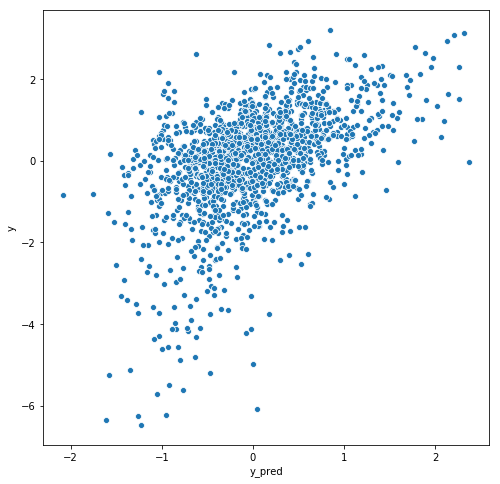

In [37]:
error_df = pd.DataFrame()
error_df['y'] = y
error_df['y_pred'] = y_pred

fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='y_pred', y='y', data=error_df);